In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize


## Exercise 1 [Convex Optimization with linear Equality]

In [12]:
import numpy as np

A = np.array([[1, 1, 1]])
b = np.array([[1]])
Q = np.array(([[10, 1, 0], [1, 100, 2], [0, 2, 1]]))

lagrange_multiplier = -np.linalg.inv(np.dot(A, np.dot(np.linalg.inv(Q), A.T))) * b
x = -np.dot(np.linalg.inv(Q), np.dot(A.T, lagrange_multiplier))

print("lagrange Multiplier is: ",lagrange_multiplier)
print("X values are:\n ",x)
print("The Sum of x is: ", sum(x))


lagrange Multiplier is:  [[-0.89878163]]
X values are:
  [[ 0.09090909]
 [-0.01030928]
 [ 0.91940019]]
The Sum of x is:  [1.]


In [13]:
def backtracking_line_search(x0, f, deltaX, df0, alpha=0.1, beta=0.7):
    """ 
    This function implements the backtracking line search method presented in the class
    
    Arguments:
    x0:  the current guess (as a numpy array)
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    deltaX: the descent direction (as a numpy vector)
    df0: the gradient of f at x0 (as a  numpy vector)
    alpha: (optional argument) parameter for the linesearch as defined in class
    beta: (optional argument) parameter for the linesearch as defined in class
    
    Returns: a number between 0 and 1.
    """
    t = 1.
    f0 = f(x0)
    while(f(x0+t*deltaX)>f0 + alpha*t*(df0.dot(deltaX))):
          t = t * beta
    return t

def gradient_descent(x0, f, df, max_n=1000, tol=10e-7):
    """
    This function implements gradient descent assuming that we have functional expressions
    for f and its gradient. It performs up to max_n iterations and stops when the new vector
    estimate is not improving any more (i.e. |x_old - x_new|<tol)
    
    Note: the stopping criteria is rather naive and could be smarter (cf. book of Boyd for 
    a better stopping criteria) - one should also check that the gradient is close to 0 - otherwise
    it might just mean that the  algorithm is stuck in a poorly conditioned part of the space
    
    Arguments:
    x0: an initial vector to start the minimization from
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    df: the gradient of the function (as a callable function), i.e. df(x0) should work
    max_n: (optional argument) the maximum number of iterations
    tol: (optional argument) the stopping criteria, if |x_old - x_new|<tol then stop
    
    Returns: a numpy 2D array x_steps containing the successive iterations.
             x_steps[0,:] contains x0 and x_steps[-1,:] contains the last estimate of x
    
    """
    x_steps = np.empty([max_n+1, x0.size]) #allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        df_current = df(x_current)
        deltaX = -df_current
        line_search = backtracking_line_search(x_current, f, deltaX, df_current)
        x_current += line_search * deltaX
        x_steps[i+1,:] = x_current

        if np.linalg.norm(x_steps[i,:]-x_current) < tol: #there was no improvement
            break
    if i==max_n-1:
        print("Reached the maximum number of iterations before convergence")
        
    return x_steps[:i+1,:]

def plot_descent1D(x_steps, x, f, title):
    """
    plots the function f in the range x and displays the steps in x_steps
    Here we assume that the function has a 1D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x: the range of  values on which to evaluate f
    f: a callable function such that f(x) works
    """
    plt.figure()

    plt.plot(x, f(x), linewidth=2)
    
    for point in x_steps:
        plt.plot(point, f(point), 'x', markersize=10, markeredgewidth=4)
    plt.xlabel('x')
    plt.ylabel('f(x)') 
    plt.title(title)
#     plt.savefig("1D_descent.png")
        
        
def plot_descent2D(x_steps, x_bounds, y_bounds, f, title, norm_scale=matplotlib.colors.Normalize()):
    """
    contour plot of the 2D function f in the interval x_bounds and y_bounds and display the steps in x_steps
    Here we assume that the function has a 2D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate x
    y_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate y
    f: a callable function such that f(x) works where x is a 2D vector
    norm_scale: (optional argument) type of color scale to use for display
    """
    plt.figure()
    
    t1 = np.linspace(x_bounds[0], x_bounds[1], 100)
    t2 = np.linspace(y_bounds[0], y_bounds[1], 100)
    tX, tY = np.meshgrid(t1, t2)
    
    f_eval = np.empty_like(tX)
    
    it = np.nditer(tX, flags=['multi_index'])
    while not it.finished:
        f_eval[it.multi_index] = f(np.array([tX[it.multi_index], tY[it.multi_index]]))
        it.iternext()
    
    plt.contourf(tX, tY, f_eval, alpha=.75, cmap='jet', norm=norm_scale)

    plt.plot(x_steps[:,0], x_steps[:,1], '-kx', markersize=10, markeredgewidth=4, linewidth=4)
    plt.title(title)
#     plt.savefig('2D_descent.png')

def compare_convergence(x_steps, p0, title, fig=None):
    """
    For each row of x_steps, plots its distance p0 (a numpy vector)
    It uses a logarithmic axis for y to show large changes of errors
    
    Arguments:
    x_steps: a 2D numpy array containing iterations of the optimizer
    p0: the optimal point to compare with
    fig: (optional) if given, the plot will be done using figure fig instead of creating a new figure 
        useful to overlay several iterations (e.g. to compare gradient descent and Newton's method)
    """
    
    if fig==None:
        fig = plt.figure()
    else:
        plt.figure(fig.number)
        
    rel_error = x_steps - p0
    plt.semilogy(range(len(x_steps[:,0])),np.linalg.norm(rel_error, axis=1))
    plt.xlabel('Number of iterations')
    plt.ylabel('Relative distance to p0')
    plt.title(title)
    return fig

##  Exercise 2 [Newton's Method]

In [14]:
def newton_method(x0, f, df, dxx, max_n=1000, tol=10e-7):
    x_steps = np.empty([max_n+1, x0.size])
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        H = np.array(dxx(x_current))
        df_current = df(x_current)
        delta_xnt = -np.dot(np.linalg.inv(H), df_current)
        lambda_2 = np.dot(df_current.transpose().dot(np.linalg.inv(H)),df_current)
        if lambda_2 / 2 <= tol:
            break
        line_search = backtracking_line_search(x_current, f, delta_xnt, df_current)
        x_current = x_current +  line_search*delta_xnt
        x_steps[i+1,:] = x_current
        
    return x_steps[:i+1,:]

## minimize the function $$f(x) = \mathrm{e}^{\frac{x^2}{100}}$$

<IPython.core.display.Javascript object>


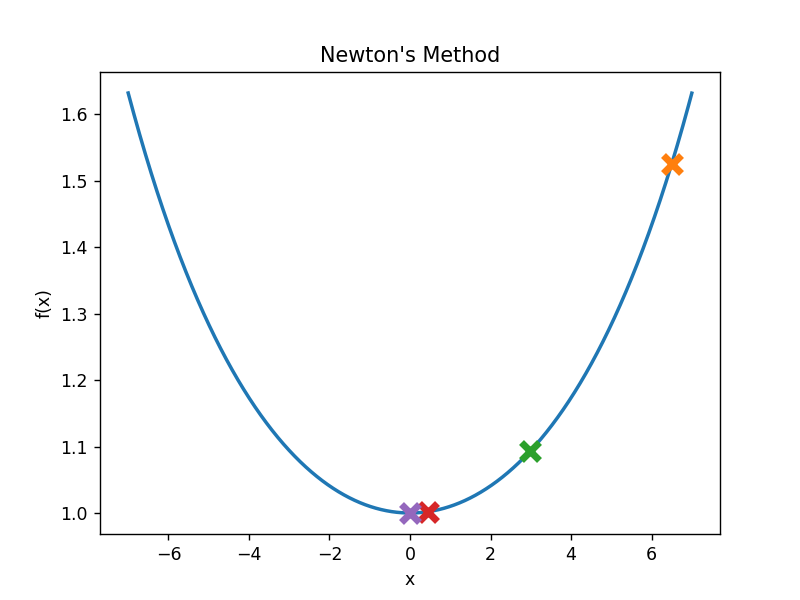

<IPython.core.display.Javascript object>


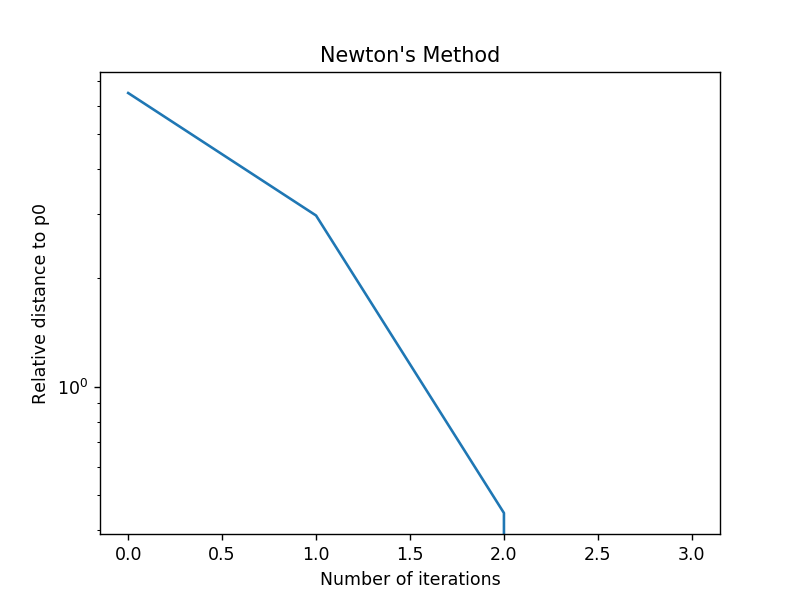

<IPython.core.display.Javascript object>


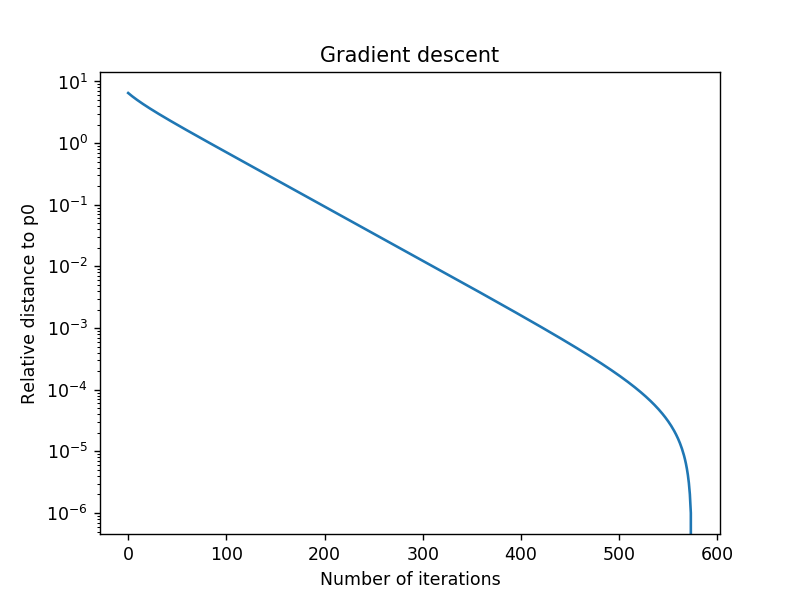

In [16]:
#initial guess
f = lambda x: np.exp(x**2 / 100.)
df = lambda x: (x/50.)*np.exp(x**2 / 100.)
x0 = np.array([6.5])

dxx = lambda x: np.array([1/50*(np.exp(x**2/100.) + (x**2/50)* np.exp(x**2/100.))])
x_steps = newton_method(x0, f, df, dxx)
x_steps_g = gradient_descent(x0, f, df)
# we  want to plot results from x=-10 to x=10
x = np.arange(-7.,7.,0.001)
# plot results

title_N = "Newton's Method"
title_G = "Gradient descent"
plot_descent1D(x_steps, x, f, title_N)
fig1 = compare_convergence(x_steps, x_steps[-1,:], title_N)
fig2 = compare_convergence(x_steps_g, x_steps_g[-1,:], title_G)
# fig1.savefig('1DN.png')
# fig2.savefig('1DG.png')

## minimize the function $$f(x) = \ x^T \begin{bmatrix}10&1\\1&10 \end{bmatrix}x$$
                                  

<IPython.core.display.Javascript object>


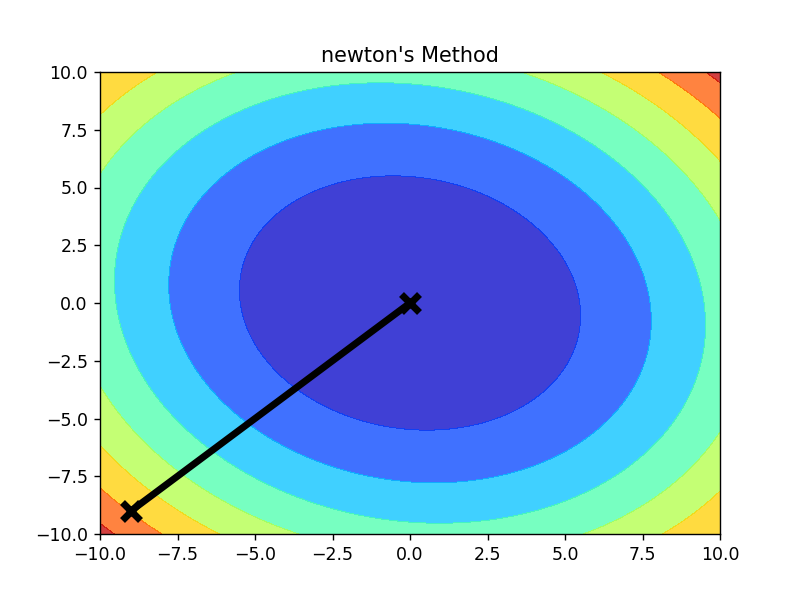

<IPython.core.display.Javascript object>


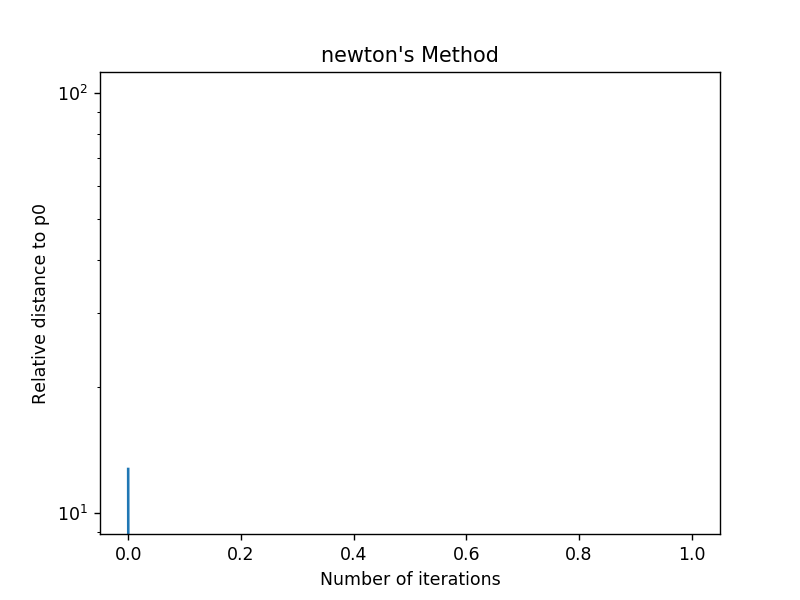

<IPython.core.display.Javascript object>


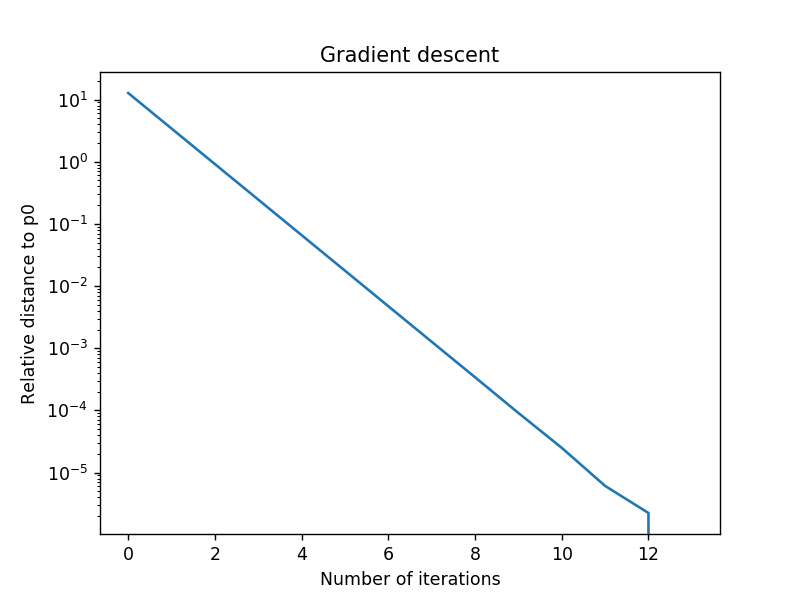

In [17]:
f = lambda x: x.dot(np.array([[10,1],[1,10]])).dot(x) # lambda function defining f(x)
df = lambda x: 2*np.array([[10,1],[1,10]]).dot(x) # lambda function defining df/dx
dxx = lambda x: 2*np.array([[10, 1], [1, 10]])
x0 = np.array([-9., -9.])

x_steps_N = newton_method(x0, f, df, dxx)
x_steps_G = gradient_descent(x0, f, df)
# we  want to plot results from x=-10 to x=10
x = np.arange(-7.,7.,0.001)
# plot results
title_N = "newton's Method"
title_G = "Gradient descent"
plot_descent2D(x_steps_N, [-10., 10.], [-10., 10.], f, title_N)
fig_N = compare_convergence(x_steps_N, x_steps_N[-1,:], title_N)
fig_G = compare_convergence(x_steps_G, x_steps_G[-1,:], title_G)
# fig_N.savefig('2DN.png')
# fig_G.savefig('2DG.png')

# Exercise 3 [Linear Least Square problem]

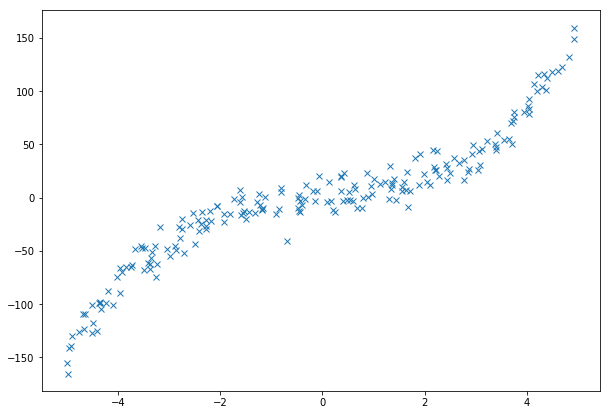

In [22]:
data = np.loadtxt('regression_dataset')

data_x = data[:,0]
data_y = data[:,1]


plt.figure(figsize=(10,7))
plt.plot(data_x, data_y, 'x')
plt.show

def do_regression_dataset(data_x, data_y, degree):
    """
    This function perform linear least squares to find a polynomial that fits the data
    
    Arguments:
    data_x: numpy array (1D) that contains the x data
    data_Y: numpy array (1D) that contains the y data
    degree: degree of  the polynomial to fit (1 is for a line)
    
    returns: an array of paramters for the fit
    """
    X = np.empty([len(data_x), degree+1])
    Y = np.empty([len(data_y)])
    # for each data point
    for i,x in enumerate(data_x):
        for j in range(degree+1):
            X[i,j] = x**j
        Y[i] = data_y[i]
    
    #construct X^T X
    XTX = X.transpose().dot(X)
    
    a = np.linalg.solve(XTX, X.transpose().dot(Y))
    
    fitting_error = (X.dot(a) - Y).dot(X.dot(a) - Y)
    
    return a, fitting_error


***Fitting results***

the regressed values are 1.620926 and 5.999623 and -0.352577 and 0.753732 and 0.020438

the fitting error is 20972.858075

Text(0.5,1,'regression_dataset')

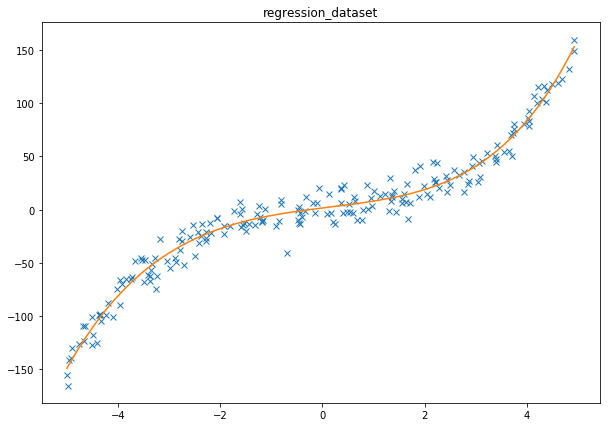

In [23]:
a, fitting_error = do_regression_dataset(data_x, data_y, 5)
display(Markdown('***Fitting results***'))
display(Markdown('the regressed values are ' + '%f'%a[0] + ' and ' + '%f'%a[1] + ' and ' + '%f'%a[2] + ' and ' + '%f'%a[3]+ ' and ' + '%f'%a[4]))
display(Markdown('the fitting error is ' +  '%f'%fitting_error))

plot_x = np.sort(data_x)

plt.figure(figsize=(10,7))
plt.plot(data_x, data_y, 'x')
plt.plot(plot_x, a[0] + a[1]*plot_x + a[2]*plot_x**2 + a[3]*plot_x**3 + a[4]*plot_x**4+a[5]*plot_x**5)
plt.title('regression_dataset')


## Fit periodic function of form $$y = a_0 + \sum_{k=1}^{K} a_kcos(kT2 \pi x) + b_k sin(kT2 \pi x) $$

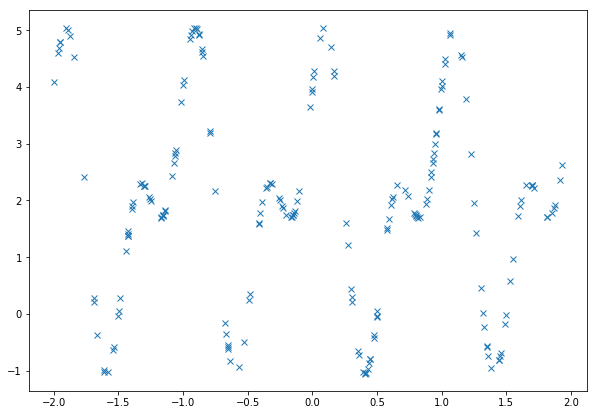

In [24]:
data = np.loadtxt('regression_dataset2')

data_x = data[:,0]
data_y = data[:,1]

plt.figure(figsize=(10,7))
plt.plot(data_x, data_y, 'x')
plt.show

def do_regression_dataset2(data_x, data_y, degree, T):
    """
    This function perform linear least squares to find a polynomial that fits the data
    
    Arguments:
    data_x: numpy array (1D) that contains the x data
    data_Y: numpy array (1D) that contains the y data
    degree: degree of  the polynomial to fit (1 is for a line)
    
    returns: an array of paramters for the fit
    """
    X = np.empty([len(data_x), degree*2+1])
    Y = np.empty([len(data_y)])
    # for each data point
    for i,x in enumerate(data_x):
        for j in range(degree+1):
            if j == 0:
                X[i,j] = 1
            else:
                X[i, 2*j-1] = np.cos(T*j*2*np.pi*x)
                X[i, 2*j] = np.sin(T*j*2*np.pi*x)
        Y[i] = data_y[i]
        
    #construct X^T X
    XTX = X.transpose().dot(X)
    
    a = np.linalg.solve(XTX, X.transpose().dot(Y))
    
    fitting_error = (X.dot(a) - Y).dot(X.dot(a) - Y)
    
    return a, fitting_error

***Fitting results***

the regressed values are 2.000000 and 2.000000 and 0.000000

the fitting error is 0.000000

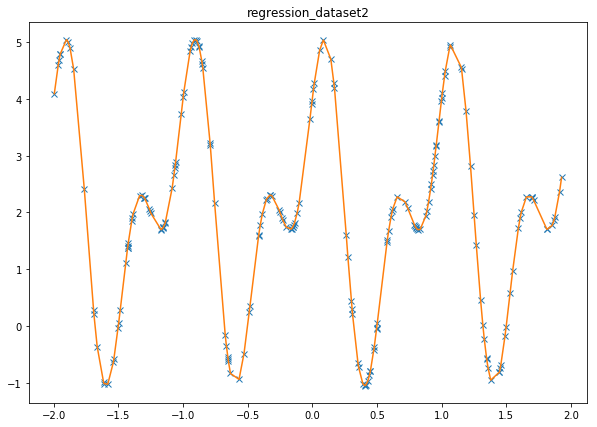

In [27]:
a, fitting_error = do_regression_dataset2(data_x, data_y, 2,T=1)

display(Markdown('***Fitting results***'))
display(Markdown('the regressed values are ' + '%f'%a[0] + ' and ' + '%f'%a[1]+ ' and ' + '%f'%a[2]))
display(Markdown('the fitting error is ' +  '%f'%fitting_error))

plot_x = np.sort(data_x)

plt.figure(figsize=(10,7))
plt.plot(data_x, data_y, 'x')
plt.plot(plot_x, a[0] + a[1]*np.cos(2*np.pi*plot_x) + a[2]*np.sin(2*np.pi*plot_x)+a[3]*np.cos(2*2*np.pi*plot_x)+a[4]*np.sin(2*2*np.pi*plot_x))
plt.title('regression_dataset2')
plt.show()